In [112]:
from tqdm import tqdm
from typing import List, Optional, Tuple
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Patch

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer

from pathai.api.slides import slides_metadata, slides, annotations
from pathai.api.monocle import slides_metadata as monocle_slides_metadata

import sys
sys.path.insert(0, '..')
import utils

In [113]:
%matplotlib inline
plt.rcParams.update({'font.size': 12})

## Load data

### HIFs

Get data for all indications

In [114]:
# initialize dictionary 
tme_hifs_dict = {}
tme_hifs_dict_transformed = {}

# non-HIF column names 
info_col_names = ['median_score', 'model_prediction', 'Class', 'train_set', 'val_set', 'test_set']

In [115]:
imputer = KNNImputer()

for indication in ['BRCA', 'BLCA', 'LUAD', 'LUSC', 'Gastric', 'PRAD']:
    
    tme_hifs_dict[indication] = pd.read_csv(f'data/{indication}_HIFs.csv').set_index('H & E_ID')
        
    # retain simple HIFs only 
    tme_hifs_dict[indication] = tme_hifs_dict[indication][tme_hifs_dict[indication].columns[~tme_hifs_dict[indication].columns.str.contains(r'(SELECTED BY|DENSITY RATIO)')]]
    # impute missing data 
    df_temp = tme_hifs_dict[indication].loc[:, ~tme_hifs_dict[indication].columns.isin(info_col_names)]
    tme_hifs_dict_transformed[indication] = pd.DataFrame(imputer.fit_transform(df_temp), 
                                                        index=df_temp.index, columns=df_temp.columns)
    
    #print(f'{indication}: ', tme_hifs_dict[indication].shape)
    print(f'{indication}: ', tme_hifs_dict_transformed[indication].shape)

BRCA:  (995, 54)
BLCA:  (455, 54)
LUAD:  (527, 54)
LUSC:  (453, 54)
Gastric:  (417, 54)
PRAD:  (814, 54)


In [116]:
for indication in ['BRCA', 'BLCA', 'LUAD', 'LUSC', 'Gastric', 'PRAD']:
    print(indication)
    print(tme_hifs_dict[indication].filter(regex='set').value_counts())

BRCA
train_set  val_set  test_set
True       False    False       596
False      False    True        214
           True     False       185
dtype: int64
BLCA
train_set  val_set  test_set
True       False    False       277
False      True     False        93
           False    True         85
dtype: int64
LUAD
train_set  val_set  test_set
True       False    False       316
False      False    True        107
           True     False       104
dtype: int64
LUSC
train_set  val_set  test_set
True       False    False       269
False      True     False        93
           False    True         91
dtype: int64
Gastric
train_set  val_set  test_set
True       False    False       249
False      True     False        87
           False    True         81
dtype: int64
PRAD
train_set  val_set  test_set
True       False    False       591
False      False    True        118
           True     False       105
dtype: int64





Combine them to one data frame

In [117]:
# untransformed 
df_tme_hifs = pd.concat(tme_hifs_dict).reset_index(level=0).rename(columns={'level_0': 'indication'})

# transformed version 
df_tme_hifs_transformed = pd.concat(tme_hifs_dict_transformed)
df_tme_hifs_transformed = df_tme_hifs_transformed.reset_index(level=0).rename(columns={'level_0': 'indication'})
df_tme_hifs_transformed.shape

(3661, 55)

Save non-HIF columns

In [118]:
indication = df_tme_hifs_transformed.pop('indication')
info_col = pd.concat([tme_hifs_dict[indication][info_col_names[1:]] for indication in tme_hifs_dict.keys()])

In [119]:
info_col['model_prediction_str'] = info_col['model_prediction'].replace({0: 'TGFb-CAF low', 1: 'TGFb-CAF high'})
info_col['Class_str'] = info_col['Class'].replace({0: 'TGFb-CAF low', 1: 'TGFb-CAF high'})

Sanity check

In [120]:
np.all(info_col.index == df_tme_hifs_transformed.index), np.all(indication.index == df_tme_hifs_transformed.index)

(True, True)

In [121]:
df_tme_hifs_transformed

,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[CANCER STROMA] OVER [HARMONIZED TUMOR]]_H & E,AREA PROP [[CANCER] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[CANCER] OVER [HARMONIZED TUMOR]]_H & E,AREA PROP [[HARMONIZED TUMOR] OVER [HARMONIZED TISSUE]]_H & E,AREA PROP [[NECROSIS] OVER [HARMONIZED TISSUE]]_H & E,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,...,DENSITY [HARMONIZED IMMUNE CELLS] IN [HARMONIZED TUMOR]_H & E,DENSITY [LYMPHOCYTE CELLS] IN [CANCER STROMA]_H & E,DENSITY [LYMPHOCYTE CELLS] IN [CANCER]_H & E,DENSITY [LYMPHOCYTE CELLS] IN [HARMONIZED TUMOR]_H & E,DENSITY [MACROPHAGE CELLS] IN [CANCER STROMA]_H & E,DENSITY [MACROPHAGE CELLS] IN [CANCER]_H & E,DENSITY [MACROPHAGE CELLS] IN [HARMONIZED TUMOR]_H & E,DENSITY [PLASMA CELLS] IN [CANCER STROMA]_H & E,DENSITY [PLASMA CELLS] IN [CANCER]_H & E,DENSITY [PLASMA CELLS] IN [HARMONIZED TUMOR]_H & E
H & E_ID,,,,,,,,,,,,,,,,,,,,,
86700,0.800859,0.802878,0.196626,0.197122,0.997485,0.002515,0.045318,0.724847,0.240829,0.760644,...,491.423279,487.813934,210.962128,433.240417,21.732784,31.459265,23.650087,37.104755,24.057085,34.532776
89379,0.875544,0.882393,0.116694,0.117607,0.992238,0.007762,0.071914,0.772293,0.243344,0.725531,...,450.820343,438.725739,327.138367,425.602356,15.681863,13.745310,15.454111,10.405722,4.948312,9.763894
88153,0.741584,0.743192,0.256253,0.256808,0.997837,0.002163,0.082246,0.840145,0.321559,0.659998,...,574.756836,641.445923,120.069122,507.552094,60.197166,4.310824,45.845097,27.031771,4.944768,21.359648
86087,0.668844,0.676058,0.320485,0.323942,0.989329,0.010671,0.215040,0.884295,0.538512,0.619216,...,447.032990,501.375702,237.859558,416.011749,27.046837,3.791150,19.513344,13.590699,7.161061,11.507870
88159,0.571635,0.572977,0.426024,0.427024,0.997659,0.002341,0.116163,0.845143,0.574226,0.692987,...,412.228516,497.739746,246.185837,390.320312,12.145480,4.979548,9.085459,17.149868,7.016636,12.822740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91723,0.537493,0.538395,0.460831,0.461605,0.998325,0.001675,0.101019,0.869869,0.561407,0.763533,...,245.864868,287.179382,100.211479,200.874130,37.662868,17.845881,28.515255,27.070187,4.118280,16.475481
91747,0.314927,0.315768,0.682410,0.684232,0.997337,0.002663,0.144936,0.895285,0.695714,0.557764,...,686.275330,1505.495117,246.375793,643.965332,67.771736,6.448690,25.812542,48.907436,1.540520,16.497475
91775,0.447703,0.448559,0.550388,0.551441,0.998091,0.001909,0.183219,0.927135,0.685435,0.720714,...,203.763123,289.274597,86.584129,177.502823,21.132072,8.785743,14.323804,25.280220,1.082302,11.936503


### Metadata

In [122]:
# metadata_dict = monocle_slides_metadata.get_slide_metadata_by_slide_ids(list(df_tme_hifs_transformed.index))
# metadata_df = pd.DataFrame()
# for element in tqdm(metadata_dict):
#     b = {key: value for key, value in element['metadata'].items()}
#     b.update({'slideId': element['slideId']})
#     metadata_df = pd.concat([metadata_df, pd.DataFrame.from_dict(b, orient='index').T], axis=0)
# metadata_df.to_csv('untracked/metadata.csv')

In [123]:
metadata_df = pd.read_csv('data/metadata.csv')

In [124]:
metadata_df.shape

(3661, 325)

In [125]:
metadata_df = metadata_df.set_index('slideId')
metadata_df = metadata_df.loc[df_tme_hifs_transformed.index, :]
metadata_df.shape

(3661, 324)

In [126]:
np.all(metadata_df.index == df_tme_hifs_transformed.index)

True

In [127]:
metadata_df['indication'] = indication
np.all(metadata_df.index == indication.index)

True

Variables of potential interest in metadata: age, sex, OS, treatment, subtype, stage, relevant mutation, etc

#### Indication

In [128]:
metadata_df[['indication', 'type']].value_counts()

indication  type
BRCA        BRCA    995
PRAD        PRAD    814
LUAD        LUAD    527
BLCA        BLCA    455
LUSC        LUSC    453
Gastric     STAD    353
            ESCA     64
dtype: int64

#### Tumor stage

In [129]:
metadata_df.filter(regex='stage').columns

Index(['clinical_stage', 'ajcc_pathologic_tumor_stage',
       'american_joint_committee_on_cancer_tumor_stage_code',
       'neoplasm_disease_lymph_node_stage_american_joint_committee_on_cancer_code',
       'neoplasm_american_joint_committee_on_cancer_clinical_primary_tumor_t_stage',
       'neoplasm_american_joint_committee_on_cancer_clinical_distant_metastasis_m_stage',
       'tnm_stage', 'disease_stage'],
      dtype='object')

In [130]:
metadata_df.loc[metadata_df.indication == 'Gastric']['ajcc_pathologic_tumor_stage'].value_counts()

Stage IIIA         77
Stage IIB          64
Stage IIIB         61
Stage IIA          40
Stage IIIC         38
Stage IB           33
Stage II           24
Stage IV           24
Stage IA           12
[Not Available]    12
[Discrepancy]      10
Stage III           9
Stage I             8
[Unknown]           3
Stage IVA           2
Name: ajcc_pathologic_tumor_stage, dtype: int64

In [131]:
metadata_df['ajcc_pathologic_tumor_stage'].value_counts()

[Not Applicable]    814
Stage IIA           484
Stage IIB           438
Stage IIIA          373
Stage IB            310
Stage IA            303
Stage IV            221
Stage II            187
Stage III           161
Stage IIIB          111
Stage I              98
Stage IIIC           97
[Discrepancy]        28
[Not Available]      20
Stage X              11
[Unknown]             3
Stage IVA             2
Name: ajcc_pathologic_tumor_stage, dtype: int64

In [132]:
metadata_df['ajcc_pathologic_tumor_stage_consolidated'] = metadata_df['ajcc_pathologic_tumor_stage'].replace({'Stage IA': 'Stage I',
                                                                                                           'Stage IB': 'Stage I',
                                                                                                           'Stage IIA': 'Stage II',
                                                                                                           'Stage IIB': 'Stage II',
                                                                                                           'Stage IIIA': 'Stage III',
                                                                                                           'Stage IIIB': 'Stage III',
                                                                                                           'Stage IIIC': 'Stage III',
                                                                                                           'Stage IVA': 'Stage IV',
                                                                                                            'Stage X': 'Other',
                                                                                                           '[Discrepancy]': 'Other',
                                                                                                           '[Not Available]': 'Other',
                                                                                                           '[Unknown]': 'Other',
                                                                                                           '[Not Applicable]': 'Other'})

In [133]:
df_tumor_stage = metadata_df.groupby(['indication','ajcc_pathologic_tumor_stage_consolidated']).size().to_frame(name='no. samples')
df_tumor_stage['percent'] = round(df_tumor_stage['no. samples'] / df_tumor_stage.groupby(['indication'])['no. samples'].transform('sum') * 100, 1)

In [134]:
df_tumor_stage

no. samples  percent
indication ajcc_pathologic_tumor_stage_consolidated                      
BLCA       Other                                               2      0.4
           Stage I                                             3      0.7
           Stage II                                          155     34.1
           Stage III                                         148     32.5
           Stage IV                                          147     32.3
BRCA       Other                                              22      2.2
           Stage I                                           163     16.4
           Stage II                                          567     57.0
           Stage III                                         226     22.7
           Stage IV                                           17      1.7
Gastric    Other                                              25      6.0
           Stage I                                            53     12.7
           Stage II                                          128     30.7
           Stage III                                         185     44.4
           Stage IV                                           26      6.2
LUAD       Other                                               9      1.7
           Stage I                                           267     50.7
           Stage II                                          129     24.5
           Stage III                                          95     18.0
           Stage IV                                           27      5.1
LUSC       Other                                               4      0.9
           Stage I                                           225     49.7
           Stage II                                          130     28.7
           Stage III                                          88     19.4
           Stage IV                                            6      1.3
PRAD       Other                                             814    100.0

#### Sex

Need to use both `sex` and `gender` columns 

In [135]:
metadata_df.sex.value_counts(dropna=False)

Male      2010
NaN       1000
Female     651
Name: sex, dtype: int64

In [136]:
metadata_df.gender.value_counts(dropna=False)

MALE      1735
FEMALE    1509
NaN        417
Name: gender, dtype: int64

In [137]:
df_sex = metadata_df.groupby(['indication','sex']).size().to_frame(name='no. samples')
df_sex['percent'] = round(df_sex['no. samples'] / df_sex.groupby(['indication'])['no. samples'].transform('sum') * 100, 1)

In [138]:
df_sex

no. samples  percent
indication sex                         
BLCA       Female          120     26.4
           Male            335     73.6
Gastric    Female          125     30.0
           Male            292     70.0
LUAD       Female          294     55.8
           Male            233     44.2
LUSC       Female          112     24.7
           Male            341     75.3
PRAD       Male            809    100.0

In [139]:
df_gender = metadata_df.groupby(['indication','gender']).size().to_frame(name='no. samples')
df_gender['percent'] = round(df_gender['no. samples'] / df_gender.groupby(['indication'])['no. samples'].transform('sum') * 100, 1)

In [140]:
df_gender

no. samples  percent
indication gender                      
BLCA       FEMALE          120     26.4
           MALE            335     73.6
BRCA       FEMALE          983     98.8
           MALE             12      1.2
LUAD       FEMALE          294     55.8
           MALE            233     44.2
LUSC       FEMALE          112     24.7
           MALE            341     75.3
PRAD       MALE            814    100.0

#### Overall survival (OS) time

In [141]:
metadata_df['os_time_quantile'] = pd.qcut(metadata_df['os_time'], 3, labels=['0-523', '524-1099', '1100-8605'])
metadata_df['os_time_quantile'] = metadata_df['os_time_quantile'].cat.add_categories('Unknown')
metadata_df['os_time_quantile'].fillna('Unknown', inplace =True) 
metadata_df['os_time_quantile'].value_counts(dropna=False)

0-523        1214
1100-8605    1214
524-1099     1213
Unknown        20
Name: os_time_quantile, dtype: int64

In [142]:
metadata_df.groupby(['indication'])['os_time'].agg(['mean', 'std'])


,mean,std
indication,,
BLCA,819.224670,773.362514
BRCA,1262.803823,1215.788275
Gastric,612.845411,532.922338
LUAD,915.864865,850.454420
LUSC,1089.615213,1103.384258
PRAD,1184.740786,754.454968


In [143]:
metadata_df.groupby(['indication'])['os_time'].agg([np.median, 'std'])


,median,std
indication,,
BLCA,563.5,773.362514
BRCA,838.0,1215.788275
Gastric,488.5,532.922338
LUAD,692.5,850.454420
LUSC,699.0,1103.384258
PRAD,1006.0,754.454968


#### Indication

In [144]:
metadata_df[['type', 'indication']].value_counts()

type  indication
BRCA  BRCA          995
PRAD  PRAD          814
LUAD  LUAD          527
BLCA  BLCA          455
LUSC  LUSC          453
STAD  Gastric       353
ESCA  Gastric        64
dtype: int64

In [145]:
metadata_df[['histologic_subtype', 'indication']].value_counts()

histologic_subtype                       indication
Acinar Adenocarcinoma                    PRAD          804
Adenocarcinoma                           LUAD          527
Squamous Cell Carcinoma                  LUSC          453
Urothelial Carcinoma                     BLCA          451
Intestinal Gastric Carcinoma             Gastric       255
Diffuse Gastric Carcinoma                Gastric        79
Adenocarcinoma, NOS                      Gastric        64
Intestinal Gastric Carcinoma (Mucinous)  Gastric        18
Adenocarcinoma                           PRAD           10
Unknown                                  BLCA            4
                                         Gastric         1
dtype: int64

In [146]:
metadata_df[['disease_name', 'indication']].value_counts()

disease_name       indication
Gastric Carcinoma  Gastric       353
dtype: int64

#### Age at initial diagnosis

In [147]:
pd.to_numeric(metadata_df['age_at_initial_pathologic_diagnosis'], errors='coerce').describe()


count    3629.000000
mean       63.146597
std        11.061819
min        26.000000
25%        56.000000
50%        64.000000
75%        71.000000
max        90.000000
Name: age_at_initial_pathologic_diagnosis, dtype: float64

In [148]:
pd.qcut(metadata_df['age_at_initial_pathologic_diagnosis'], 3).value_counts()

(25.999, 59.0]    1294
(68.0, 90.0]      1202
(59.0, 68.0]      1133
Name: age_at_initial_pathologic_diagnosis, dtype: int64

In [149]:
metadata_df['age_at_initial_pathologic_diagnosis_quantile'] = pd.qcut(metadata_df['age_at_initial_pathologic_diagnosis'], 3, labels=['26-59', '60-68', '69-90'])
metadata_df['age_at_initial_pathologic_diagnosis_quantile'] = metadata_df['age_at_initial_pathologic_diagnosis_quantile'].cat.add_categories('Unknown')
metadata_df['age_at_initial_pathologic_diagnosis_quantile'].fillna('Unknown', inplace =True) 
metadata_df['age_at_initial_pathologic_diagnosis_quantile'].value_counts(dropna=False)

26-59      1294
69-90      1202
60-68      1133
Unknown      32
Name: age_at_initial_pathologic_diagnosis_quantile, dtype: int64

In [150]:
metadata_df.groupby(['indication'])['age_at_initial_pathologic_diagnosis'].agg(['mean', 'std'])

,mean,std
indication,,
BLCA,67.854945,10.633712
BRCA,58.574447,13.265854
Gastric,64.709443,10.549368
LUAD,65.704724,10.238354
LUSC,67.667416,8.472369
PRAD,61.237101,6.989646


In [151]:
metadata_df.groupby(['indication'])['age_at_initial_pathologic_diagnosis'].agg([np.median, 'std'])

,median,std
indication,,
BLCA,69.0,10.633712
BRCA,58.5,13.265854
Gastric,66.0,10.549368
LUAD,67.0,10.238354
LUSC,68.0,8.472369
PRAD,62.0,6.989646


#### OS

In [152]:
metadata_df.columns

Index(['Unnamed: 0', 'os', 'dfi', 'dss', 'pfi', 'pfs', 'sex', 'case', 'race',
       'type',
       ...
       'histologic_subtype_adenocarcinoma',
       'histologic_subtype_squamous_cell_carcinoma', 'case_name',
       'disease_name', 'partner_short_name', 'diagnosis_hist_sub_original',
       'indication', 'ajcc_pathologic_tumor_stage_consolidated',
       'os_time_quantile', 'age_at_initial_pathologic_diagnosis_quantile'],
      dtype='object', length=328)

In [153]:
df_os = metadata_df.groupby(['indication', 'os']).size().to_frame(name='no. samples')
df_os['percent'] = round(df_os['no. samples'] / df_os.groupby(['indication'])['no. samples'].transform('sum') * 100, 1)

In [154]:
df_os

no. samples  percent
indication os                       
BLCA       0.0          243     53.4
           1.0          212     46.6
BRCA       0.0          856     86.0
           1.0          139     14.0
Gastric    0.0          246     59.0
           1.0          171     41.0
LUAD       0.0          315     59.8
           1.0          212     40.2
LUSC       0.0          252     55.6
           1.0          201     44.4
PRAD       0.0          787     96.7
           1.0           27      3.3

## Data transformation

### Quantile transformer

In [155]:
qt = QuantileTransformer(n_quantiles=100)
df_qt = pd.DataFrame(qt.fit_transform(df_tme_hifs_transformed),
                     index=df_tme_hifs_transformed.index, columns=df_tme_hifs_transformed.columns)

### Power transformer

In [156]:
pt = PowerTransformer()
df_pt = pd.DataFrame(pt.fit_transform(df_tme_hifs_transformed),
                     index=df_tme_hifs_transformed.index, columns=df_tme_hifs_transformed.columns)

## Clustering

In [157]:
spacecadet_cmap = sns.light_palette("#2D2849")

### All TME HIFs

In [158]:
df_qt.shape, df_pt.shape

((3661, 54), (3661, 54))

In [159]:
df_qt.filter(regex='CANCER.*CELL')

,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E,COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E,DENSITY [CANCER CELLS] IN [CANCER STROMA]_H & E,DENSITY [CANCER CELLS] IN [CANCER]_H & E,DENSITY [CANCER CELLS] IN [HARMONIZED TUMOR]_H & E
H & E_ID,,,,,,
86700,0.237795,0.162746,0.175542,0.161647,0.166484,0.121368
89379,0.355475,0.249867,0.177490,0.203390,0.355209,0.095799
88153,0.397007,0.449140,0.252800,0.292471,0.137469,0.166430
86087,0.780285,0.621730,0.508443,0.657822,0.643915,0.438765
88159,0.524533,0.462967,0.551112,0.385733,0.570842,0.461089
...,...,...,...,...,...,...
91723,0.464467,0.563358,0.536996,0.330722,0.277249,0.375432
91747,0.616144,0.663388,0.708463,0.702244,0.755732,0.805230
91775,0.713901,0.825031,0.696977,0.621596,0.608385,0.607722


Color dictionary for row and column color bars:

In [160]:
hif_cell_type = df_qt.columns.map(utils.get_cell)
hif_cell_type = hif_cell_type.fillna('NA')
hif_cell_type.value_counts()

LYMPHOCYTE                  9
MACROPHAGE                  9
PLASMA                      9
NA                          6
CANCER                      6
FIBROBLAST                  6
HARMONIZED IMMUNE           6
HARMONIZED ALL PREDICTED    3
dtype: int64

In [161]:
info_col['model_prediction_str'].unique()

array(['TGFb-CAF high', 'TGFb-CAF low'], dtype=object)

In [162]:
info_col['model_prediction_str'].unique()

array(['TGFb-CAF high', 'TGFb-CAF low'], dtype=object)

In [163]:
# indication
color_dict_indication = dict(zip(['BRCA', 'BLCA', 'LUAD', 'LUSC', 'Gastric', 'PRAD'], 
                                 ['#ffbfc3', '#0077C8', '#097969', '#AAFF00', '#800080', '#ADD8E6']))
indication_colors = metadata_df['indication'].map(color_dict_indication)

# model prediction
color_dict_modelpred = dict(zip(['TGFb-CAF high', 'TGFb-CAF low'], ['#4CEAD3', '#793EF8']))
model_prediction_colors = info_col['model_prediction_str'].map(color_dict_modelpred)

# cell type
hif_cell_type = df_qt.columns.map(utils.get_cell)
hif_cell_type = hif_cell_type.fillna('NA')
cell_types = ['CANCER', 'FIBROBLAST', 'PLASMA', 'LYMPHOCYTE',  
              'MACROPHAGE', 'NA', 'HARMONIZED IMMUNE', 'HARMONIZED ALL PREDICTED']
cell_types_labels = ['Cancer cell', 'Fibroblast',  'Plasma cell', 'Lymphocyte',
                     'Macrophage']
cell_types_colors = ['#F93A00', '#FB8741',  '#FFEEAC', '#36B279', '#015f7d', 'white', 'white', 'white'] #'#00AFE7']
color_dict_celltype = {cell_type: color for cell_type, color in zip(cell_types, cell_types_colors)}
cell_colors = pd.Series(hif_cell_type, index=df_qt.columns).map(color_dict_celltype)

# tissue type 
hif_tissue_type = df_qt.columns.map(utils.get_tissue)
tissue_types = ['CANCER', 'CANCER STROMA', 'NECROSIS', 'HARMONIZED TUMOR']
tissue_types_labels = ['Cancer', 'Cancer stroma', 'Necrosis']
tissue_types_colors = ['#D500FA', '#FBB830', '#000000', 'white']
color_dict_tissuetype = {tissue_type: color for tissue_type, color in zip(tissue_types, tissue_types_colors)}
tissue_colors = pd.Series(hif_tissue_type, index=df_qt.columns).map(color_dict_tissuetype) 

# OS 
color_dict_os = dict(zip(['0-523', '524-1099', '1100-8605', 'Unknown'], ['lightgray', 'grey', 'black', 'white']))
os_colors = metadata_df['os_time_quantile'].map(color_dict_os)

# tumor stage 
color_dict_tumor_stage = dict(zip(['Stage ' + stage_number for stage_number in ['I', 'II', 'III', 'IV'] ]+['Other'], ['lightsalmon', 'salmon', 'orangered', 'darkred', 'white']))
                                  #cm.get_cmap('Reds', 6)(np.linspace(0, 1, 6))))
tumor_stage_colors = metadata_df['ajcc_pathologic_tumor_stage_consolidated'].map(color_dict_tumor_stage)

# age
color_dict_age = dict(zip(['26-59', '60-68', '69-90', 'Unknown'], ['thistle', 'violet', 'purple', 'white']))
age_colors = metadata_df['age_at_initial_pathologic_diagnosis_quantile'].map(color_dict_age)

# tp53 
#color_dict_tp53 = dict(zip([0, 1], ['yellow', 'green']))
#tp53_labels = ['Low', 'High']
#tp53_colors = metadata_df['TP53'].map(color_dict_tp53)


### Area HIFs

In [164]:
areaprop_over_tissue = ['AREA PROP [[CANCER STROMA] OVER [HARMONIZED TISSUE]]_H & E',
                        'AREA PROP [[CANCER] OVER [HARMONIZED TISSUE]]_H & E',
                        'AREA PROP [[NECROSIS] OVER [HARMONIZED TISSUE]]_H & E']

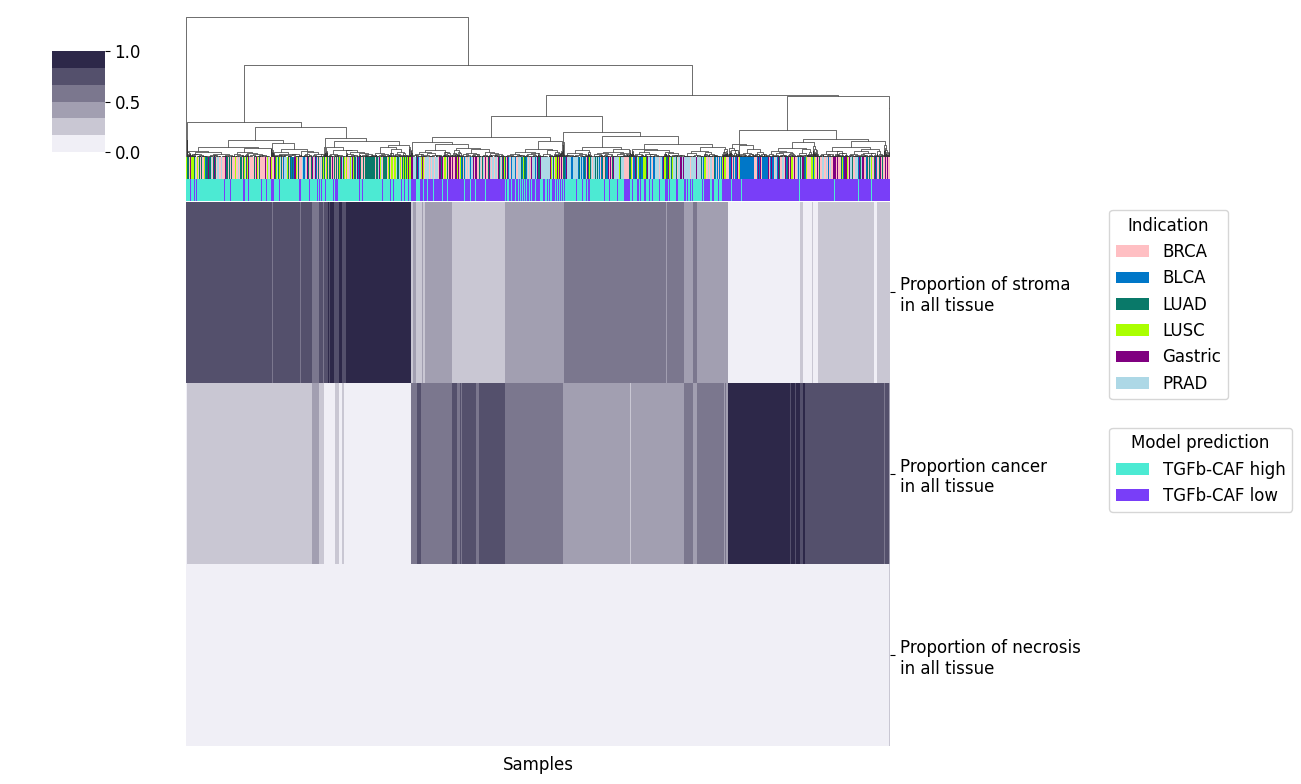

In [165]:
g = sns.clustermap(df_tme_hifs.loc[:, areaprop_over_tissue].dropna().T, method='average', metric='euclidean', 
                   z_score=None, xticklabels=False, yticklabels=True, cmap=spacecadet_cmap, row_cluster=False, col_cluster=True,
                   col_colors=[indication_colors, model_prediction_colors], figsize=(15, 8)
                  )
ax = g.ax_heatmap 
_x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([_x0+0.02, _y0, g.ax_row_dendrogram.get_position().width * 0.3, _h * 0.7])
ax.set_xlabel("Samples")
ax.set_yticklabels(['Proportion of stroma\nin all tissue', 'Proportion cancer\nin all tissue', 'Proportion of necrosis\nin all tissue'])
handles = [Patch(facecolor=color_dict_indication[name]) for name in color_dict_indication]
legend_one = ax.legend(handles, color_dict_indication, title='Indication',
           bbox_to_anchor=(1.3, 1.0), loc='upper left')
ax.add_artist(legend_one)
handles2 = [Patch(facecolor=color_dict_modelpred[name]) for name in color_dict_modelpred]
ax.legend(handles2, color_dict_modelpred, title='Model prediction',
           bbox_to_anchor=(1.3, 0.6), loc='upper left')
#plt.savefig("untracked/fig_6d_heatmap_tissue_proportion.svg")

### Cell prop HIFs

In [166]:
countprop_in_tumor = df_qt.filter(regex=r'(?<!\[HARMONIZED IMMUNE CELLS\]) OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[HARMONIZED TUMOR\]_H & E').columns

In [167]:
countprop_in_tumor

Index(['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E'],
      dtype='object')

In [168]:
countprop_in_cancer = list(df_tme_hifs.filter(regex='(?<!\[HARMONIZED IMMUNE CELLS\]) OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[CANCER\]_H & E').columns)

In [169]:
countprop_in_cancer

['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E',
 'COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E',
 'COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E',
 'COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E',
 'COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER]_H & E']

In [170]:
countprop_in_stroma = list(df_tme_hifs.filter(regex='(?<!\[HARMONIZED IMMUNE CELLS\]) OVER \[HARMONIZED ALL PREDICTED CELLS\]\] IN \[CANCER STROMA\]_H & E').columns)

In [171]:
countprop_in_stroma

['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E',
 'COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E',
 'COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E',
 'COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E',
 'COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [CANCER STROMA]_H & E']

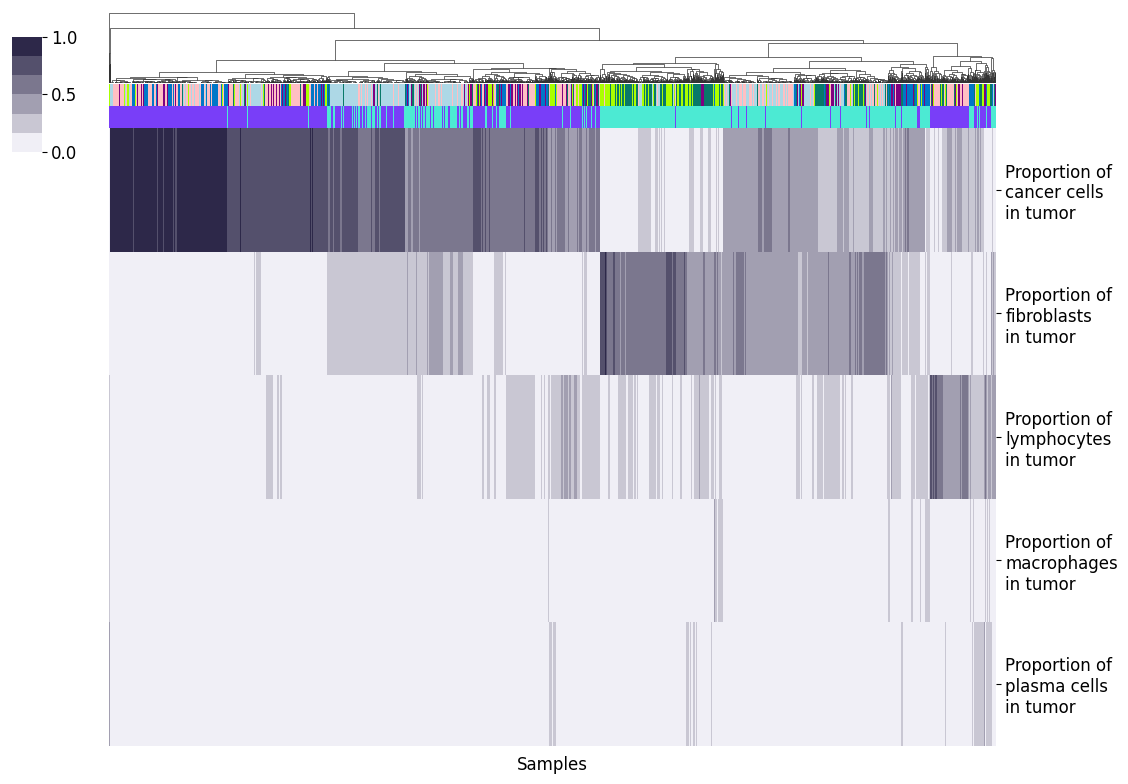

In [172]:
g = sns.clustermap(df_tme_hifs.loc[:, countprop_in_tumor].dropna().T, method='average', metric='euclidean', 
                   z_score=None, xticklabels=False, yticklabels=True, cmap=spacecadet_cmap, dendrogram_ratio=(.1, .1), col_cluster=True, row_cluster=False,
                   col_colors=[indication_colors, model_prediction_colors], figsize=(20, 8))
_x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([_x0-0.01, _y0, g.ax_row_dendrogram.get_position().width * 0.3, _h * 0.8])
ax = g.ax_heatmap 
ax.set_xlabel("Samples")
ax.set_yticklabels(['Proportion of\ncancer cells\nin tumor', 'Proportion of\nfibroblasts\nin tumor', 'Proportion of\nlymphocytes\nin tumor', 
                    'Proportion of\nmacrophages\nin tumor', 'Proportion of\nplasma cells\nin tumor'])
handles1 = [Patch(facecolor=color_dict_indication[name]) for name in color_dict_indication]
legend1 = ax.legend(handles1, color_dict_indication, title='Indication',
           bbox_to_anchor=(1.17, 1.0), loc='upper left')
ax.add_artist(legend1)
handles2 = [Patch(facecolor=color_dict_modelpred[name]) for name in color_dict_modelpred]
legend2 = ax.legend(handles2, color_dict_modelpred, title='Model prediction',
           bbox_to_anchor=(1.17, 0.6), loc='upper left')
ax.add_artist(legend2)
#plt.savefig("untracked/fig_6e_heatmap_cell_props_in_tumor.svg")

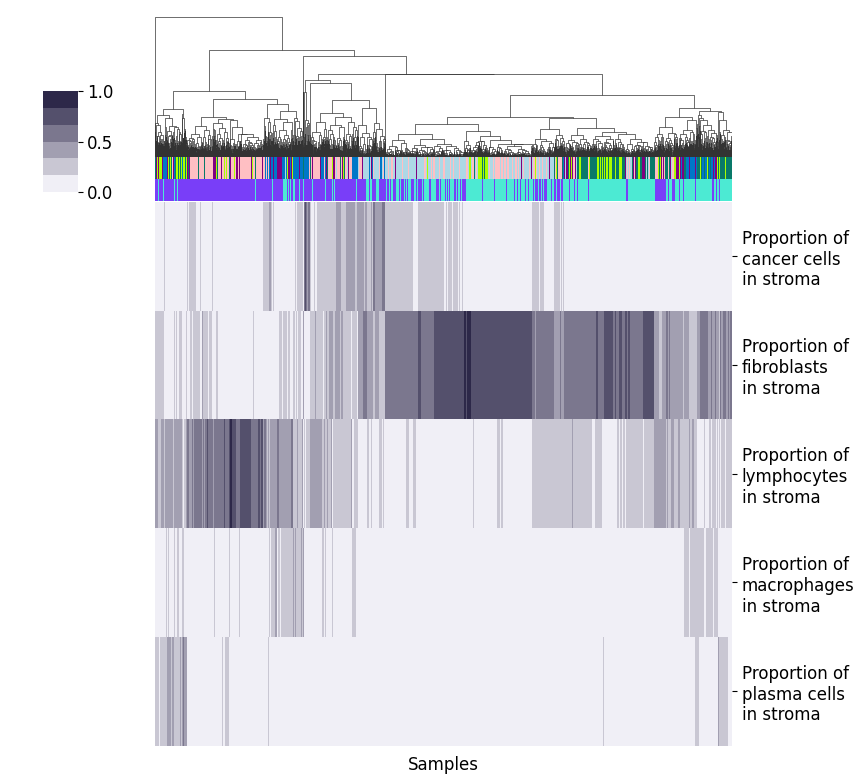

In [173]:
g = sns.clustermap(df_tme_hifs.loc[:, countprop_in_stroma].dropna().T, method='average', metric='euclidean', 
                   z_score=None, figsize=(17, 8), yticklabels=True, xticklabels=False,
                   cmap=spacecadet_cmap, row_cluster=False, col_cluster=True,
                   col_colors=[indication_colors, model_prediction_colors])
_x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([_x0+0.01, _y0 - 0.05, g.ax_row_dendrogram.get_position().width * 0.24, _h * 0.7])

ax = g.ax_heatmap 
ax.set_xlabel("Samples")
ax.set_yticklabels(['Proportion of\ncancer cells\nin stroma', 'Proportion of\nfibroblasts\nin stroma', 'Proportion of\nlymphocytes\nin stroma', 
                    'Proportion of\nmacrophages\nin stroma', 'Proportion of\nplasma cells\nin stroma'])
handles1 = [Patch(facecolor=color_dict_indication[name]) for name in color_dict_indication]
legend1 = ax.legend(handles1, color_dict_indication, title='Indication',
           bbox_to_anchor=(1.25, 1.0), loc='upper left')
ax.add_artist(legend1)
handles2 = [Patch(facecolor=color_dict_modelpred[name]) for name in color_dict_modelpred]
legend2 = ax.legend(handles2, color_dict_modelpred, title='Model prediction',
           bbox_to_anchor=(1.25, 0.6), loc='upper left')
ax.add_artist(legend2)
#plt.savefig("untracked/fig_6f_heatmap_cell_props_in_stroma.svg")

### Area HIFs + cell prop HIFs 


In [174]:
all_prop_feats = areaprop_over_tissue + countprop_in_cancer + countprop_in_stroma
all_prop_feats_labels = ['Stroma proportion in all tissue', 'Cancer proportion in all tissue', 'Necrosis proportion in all tissue', 
                        'Cancer cell proportion in cancer', 'Fibroblast proportion in cancer', 'Lymphocyte proportion in cancer', 
                    'Macrophage proportion in cancer', 'Plasma cell proportion in cancer',
                       'Cancer cell proportion in stroma', 'Fibroblast proportion in stroma', 'Lymphocyte proportion in stroma', 
                    'Macrophage proportion in stroma', 'Plasma cell proportion in stroma']

In [175]:
temp = df_tme_hifs.loc[:, all_prop_feats]
temp.columns = all_prop_feats_labels

In [176]:
# cell type
hif_cell_type = list(map(utils.get_cell, all_prop_feats))
hif_cell_type = pd.Series(hif_cell_type).fillna('NA').tolist()
cell_colors = pd.Series(hif_cell_type, index=all_prop_feats).map(color_dict_celltype)

# tissue type 
hif_tissue_type = list(map(utils.get_tissue, all_prop_feats))
hif_tissue_type = pd.Series(hif_tissue_type).fillna('NA').tolist()
tissue_colors = pd.Series(hif_tissue_type, index=all_prop_feats).map(color_dict_tissuetype) 

In [177]:
color_dict_tissuetype

{'CANCER': '#D500FA',
 'CANCER STROMA': '#FBB830',
 'NECROSIS': '#000000',
 'HARMONIZED TUMOR': 'white'}

In [178]:
[Patch(facecolor=color_dict_tissuetype[name]) for name in color_dict_tissuetype if color_dict_tissuetype[name] == 'white' ]

## Stacked barplot

### Area prop

In [179]:
info_col['Class_str'].unique()

array(['TGFb-CAF high', 'TGFb-CAF low'], dtype=object)

In [180]:
# indication
color_dict_indication = dict(zip(metadata_df['indication'].unique(), ['#ffbfc3', '#0077C8', '#097969', '#AAFF00', '#800080', '#ADD8E6']))
indication_colors = metadata_df['indication'].map(color_dict_indication)

# model prediction
color_dict_class = dict(zip(info_col['Class_str'].unique(), ['#F4C2C2', '#A9A9A9']))
class_colors = info_col['Class_str'].map(color_dict_class)

In [181]:
def plot_stacked_barplots(hifs: pd.DataFrame, 
                          group_labels: pd.Series,  
                          feats: List[str], 
                          colors: List[str], 
                          title: str = '', 
                          width: float=0.25, 
                          xticks = False, 
                          figsize = (20, 5), 
                          fname: str = None, 
                          legend: bool = True,
                          legend_labels: List[str] = None,
                          ymax: float = 100,
                          xlab: str = '', 
                          ylab: str = ''):
    """Plots stacked barplots plus indication and ground truth color bars."""
    
    (fig, axes) = plt.subplots(3, 1, figsize=figsize, gridspec_kw={'height_ratios': [5, 1, 1]})
    tt = pd.DataFrame(columns = feats + ['indication'])
    for group in np.unique(group_labels):
        id_slides = hifs.index[group_labels == group]
        tt = pd.concat([tt, hifs.loc[id_slides, tt.columns].sort_values(by=feats, ascending=False)])
    ind = np.arange(tt.shape[0]) + 1 #/ 2
    bottom = np.zeros(len(ind))

    for i, col in enumerate(feats):
        axes[0].bar(ind, tt.loc[:, col], bottom=bottom, width=1.0, color=colors[i], align='center')
        bottom = bottom + tt.loc[:, col]
    if legend_labels is None:
        labels = [re.search(r'^.*\[\[(?P<stroma>.*?)\]', feat, re.IGNORECASE).group('stroma') for feat in feats]
    else: 
        labels = legend_labels
    if legend:
        axes[0].legend(labels=labels, loc='upper left',  frameon=False, bbox_to_anchor=(1.01, 1.0),
                 fontsize=15, ncol=1)
    axes[0].set_ylabel(ylab, fontsize=15)
    axes[0].set_xlabel(xlab, fontsize=15)
    axes[0].set_ylim(0, ymax)
    axes[0].set_xlim(0.8, ind[-1] + 0.3)
    axes[0].tick_params(axis='both', which='major', labelsize=15)
    axes[0].axes.get_xaxis().set_ticks([])
    
    axes[1].bar(ind, [0.2]*len(ind), width=1.0, color=class_colors.loc[tt.index], align='center')
    axes[1].set_xlim(0.8, ind[-1] + 0.3)
    axes[1].set_ylim(0, 0.2)
    axes[1].set_ylabel('Ground truth', fontsize=15, rotation=0, ha='right')
    axes[1].tick_params(axis='both', which='major', labelsize=15)
    axes[1].axes.get_yaxis().set_ticks([])
    axes[1].axes.get_xaxis().set_ticks([])
    handles1 = [Patch(facecolor=color, label=label) for label, color in color_dict_class.items()]
    legend1 = axes[1].legend(handles=handles1, loc='upper left',  frameon=False, bbox_to_anchor=(1.01, 1.01),
             fontsize=15, ncol=1)
    axes[1].add_artist(legend1)
    
    axes[2].bar(ind, [0.2]*len(ind), width=1.0, color=indication_colors.loc[tt.index], align='center')
    axes[2].set_xlim(0.8, ind[-1] + 0.3)
    axes[2].set_ylim(0, 0.2)
    axes[2].set_ylabel('Indication', fontsize=15, rotation=0, ha='right')
    axes[2].set_xlabel('No. slides', fontsize=15)
    axes[2].tick_params(axis='both', which='major', labelsize=15)
    axes[2].axes.get_yaxis().set_ticks([])
    handles2 = [Patch(facecolor=color, label=label) for label, color in color_dict_indication.items()]
    legend2 = axes[2].legend(handles=handles2, loc='upper left',  frameon=False, bbox_to_anchor=(1.01, 1.01),
             fontsize=15, ncol=int(len(color_dict_indication)/2))
    axes[2].add_artist(legend2)

    
    if fname != None:
        plt.savefig(fname, dpi=1200, facecolor='white', bbox_inches='tight')

In [182]:
tissue_types = ['CANCER', 'CANCER STROMA', 'NECROSIS']
tissue_types_labels = ['Cancer', 'Cancer stroma', 'Necrosis']
areaprop_feats = [f'AREA PROP [[{tissue}] OVER [HARMONIZED TISSUE]]_H & E' for tissue in tissue_types] 
tissue_colors = ('#D500FA', '#FBB830', '#000000')


All indications; test set only 

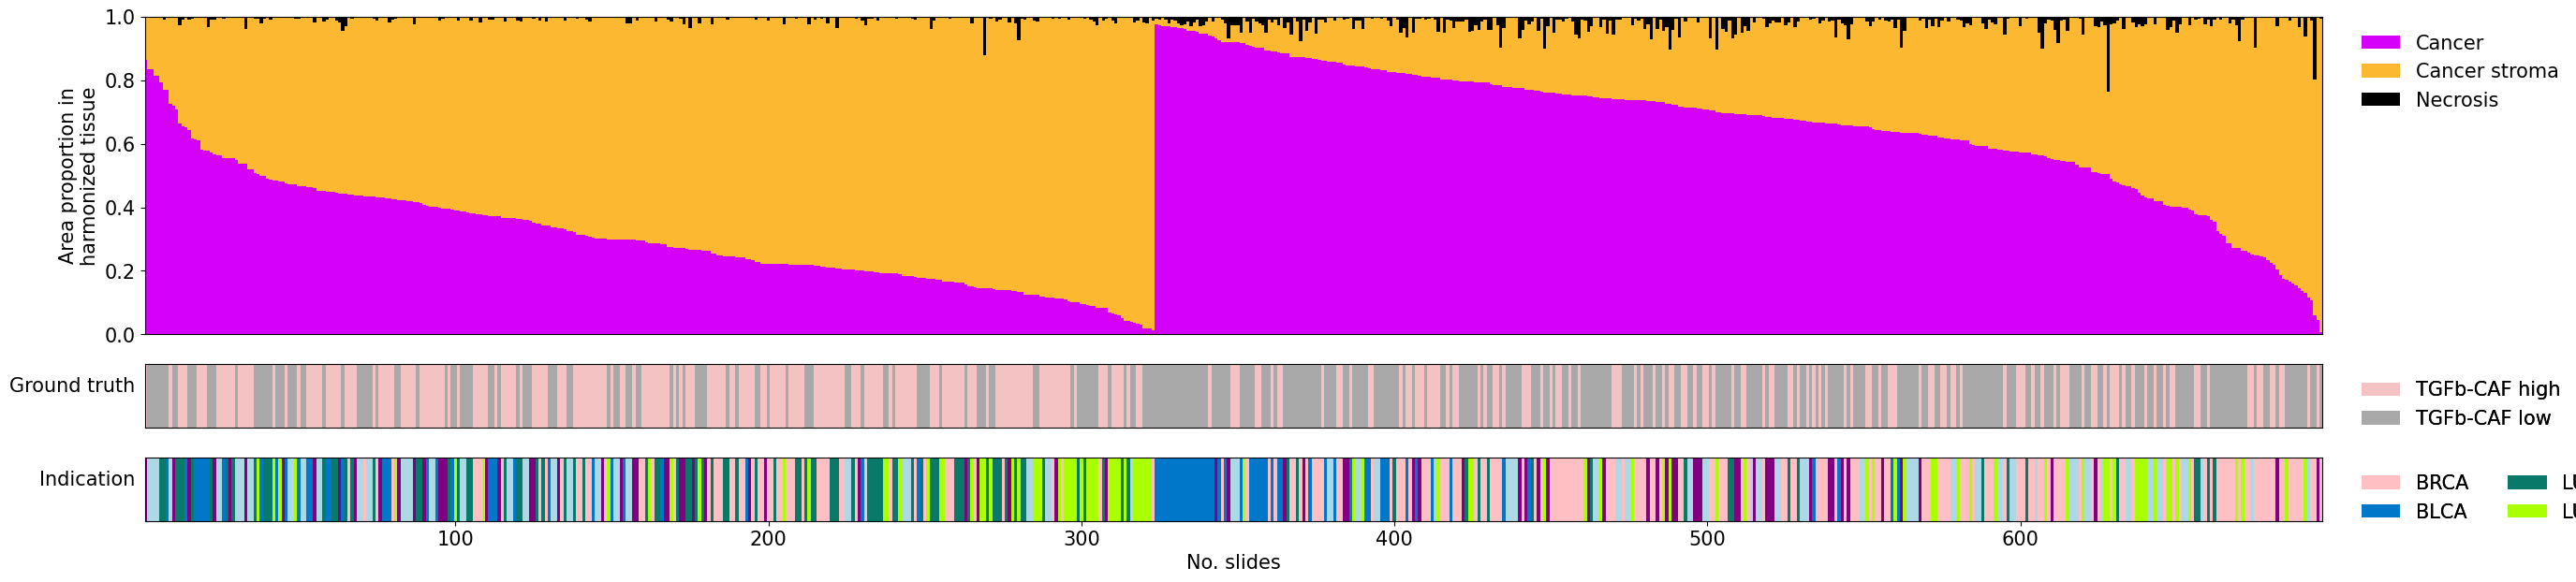

In [183]:
plot_stacked_barplots(df_tme_hifs.loc[df_tme_hifs.test_set == True, :], 
                     info_col['model_prediction_str'][df_tme_hifs.test_set == True], 
                     areaprop_feats, 
                     figsize=(30,7),
                     colors=tissue_colors,
                     ylab='Area proportion in\nharmonized tissue',
                     legend_labels=tissue_types_labels,
                     ymax=1,)      

### Cell count prop in tumor

In [184]:
cell_types = ['CANCER CELL', 'FIBROBLAST', 'PLASMA CELL', 'LYMPHOCYTE',  
              'MACROPHAGE']
cell_types_labels = ['Cancer cell', 'Fibroblast',  'Plasma cell', 'Lymphocyte',
                     'Macrophage']
cell_types_colors = ['#F93A00', '#FB8741',  '#FFEEAC', '#36B279', '#015f7d'] #'#00AFE7']
countprop_in_tumor

Index(['COUNT PROP [[CANCER CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[FIBROBLAST CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[LYMPHOCYTE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[MACROPHAGE CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E',
       'COUNT PROP [[PLASMA CELLS] OVER [HARMONIZED ALL PREDICTED CELLS]] IN [HARMONIZED TUMOR]_H & E'],
      dtype='object')

All indications; test set only 

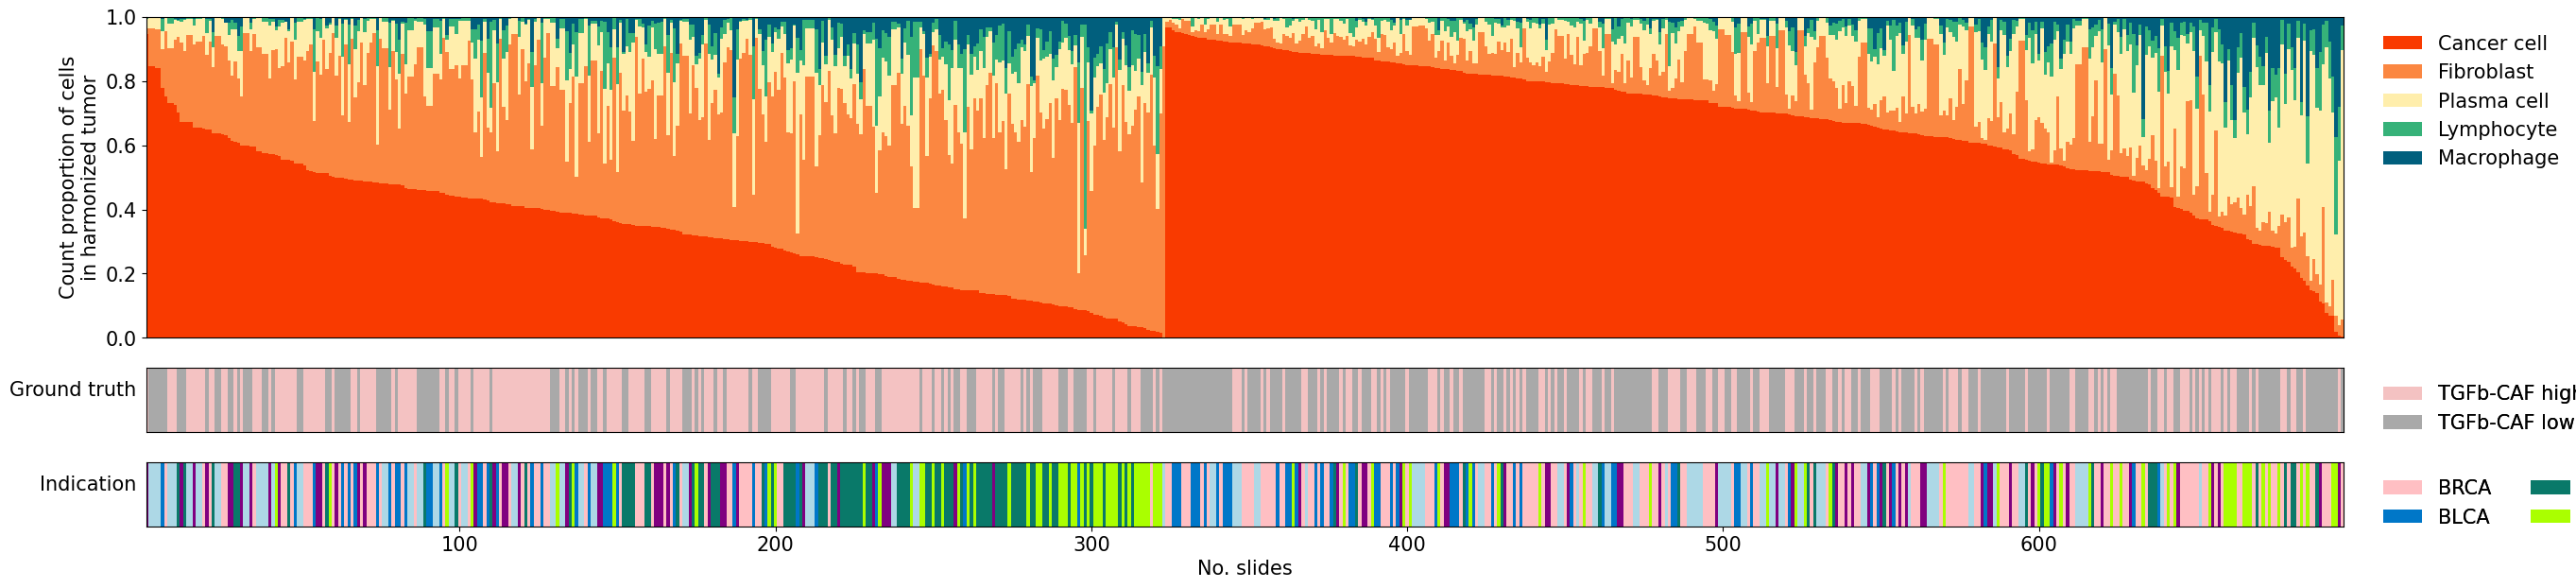

In [185]:
plot_stacked_barplots(df_tme_hifs.loc[df_tme_hifs.test_set == True, :], 
                     info_col['model_prediction_str'][df_tme_hifs.test_set == True], 
                     list(countprop_in_tumor),
                     figsize=(30,7),
                     colors=cell_types_colors,
                     ylab='Count proportion of cells\nin harmonized tumor',
                     legend_labels=cell_types_labels,
                     ymax=1,)      

### Cell count prop in stroma

All indications; test set only 

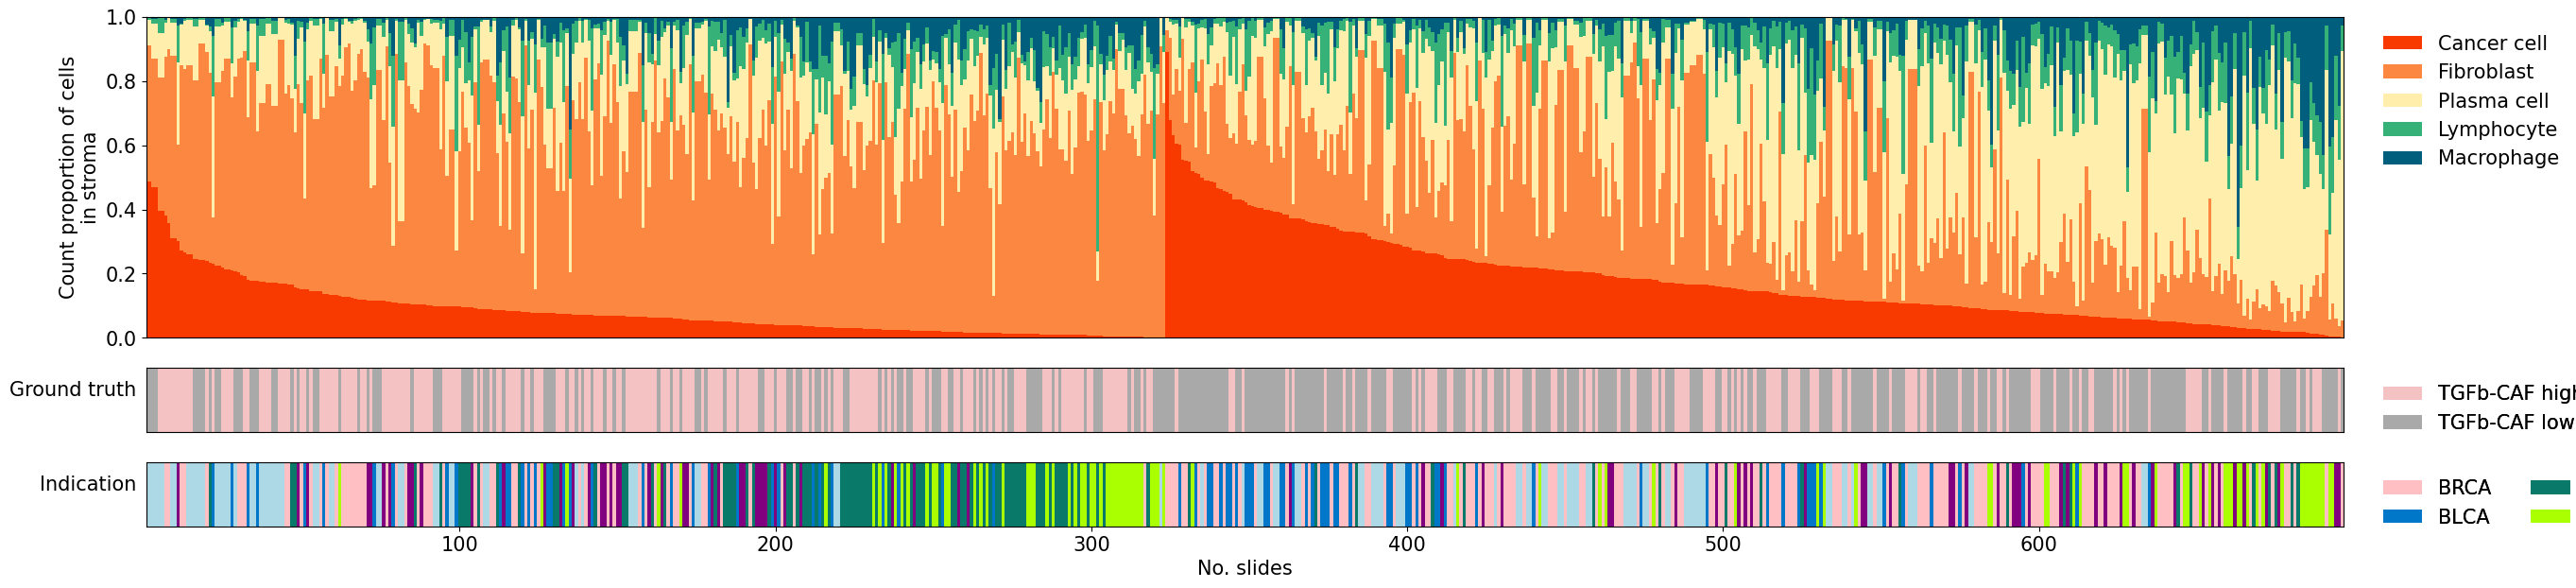

In [186]:
plot_stacked_barplots(df_tme_hifs.loc[df_tme_hifs.test_set == True, :], 
                     info_col['model_prediction_str'][df_tme_hifs.test_set == True], 
                     list(countprop_in_stroma),
                     figsize=(30,7),
                     colors=cell_types_colors,
                     ylab='Count proportion of cells\nin stroma',
                     legend_labels=cell_types_labels,
                     ymax=1,)      